In [1]:
!pip uninstall -y transformers
!pip install transformers==4.44.2 datasets==2.19.0

Found existing installation: transformers 5.0.0
Uninstalling transformers-5.0.0:
  Successfully uninstalled transformers-5.0.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 59.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface_hub 1.4.0
    Uninstalling huggingface_hub-1.4.0:
      Successfully uninstalled huggingface_hub-1.4.0
  Attempting uninstall: tokenizers
    Found exi

In [2]:
import transformers

In [3]:
from datasets import load_dataset

In [4]:
from transformers import DataCollatorForWholeWordMask, AutoTokenizer, AutoModelForMaskedLM, Trainer, TrainingArguments, pipeline, BertTokenizerFast, BertTokenizer, EarlyStoppingCallback

In [14]:
from tokenizers import BertWordPieceTokenizer

In [13]:
import requests

In [5]:
import os
import shutil

In [6]:
# MODEL_NAME = "DeepPavlov/rubert-base-cased" # или "DeepPavlov/bert-base-bg-cs-pl-ru-cased"
MODEL_NAME = "DeepPavlov/bert-base-bg-cs-pl-ru-cased"

In [7]:
OUTPUT_DIR = "old_russian_slavic_bert_finetune2"

In [8]:
TRAIN_FILE = "final_dataset_clean.txt"

In [9]:
VOCAB_DIR = "./custom_vocab_dir"

In [10]:
ORIGINAL_FILE = "vocab_extended.txt"

In [11]:
VOCAB_SIZE_LIMIT = 5000

In [15]:
vocab_url = "https://huggingface.co/DeepPavlov/bert-base-bg-cs-pl-ru-cased/resolve/main/vocab.txt"
try:
    r = requests.get(vocab_url)
    original_vocab = r.text.splitlines()
    print(f" Downloader.{len(original_vocab)} tokens in the dataset")
except Exception as e:
    raise ValueError(f"Error: {e}")

 Downloader.119547 tokens in the dataset


In [16]:
with open(TRAIN_FILE, 'r', encoding='utf-8') as f:
    text_content = f.read()

In [17]:
existing_vocab_set = set(original_vocab)
tokens_to_append = []

In [18]:
unique_chars = set(text_content)
chars_found = 0

In [19]:
for c in unique_chars:
    if c.strip(): # Пропускаем пробелы
        # 1. Добавляем саму букву (для начала слова)
        if c not in existing_vocab_set and c not in tokens_to_append:
            tokens_to_append.append(c)
            chars_found += 1

        # 2. ВАЖНО: Добавляем вариант с ## (для середины слова)
        sub_c = "##" + c
        if sub_c not in existing_vocab_set and sub_c not in tokens_to_append:
            tokens_to_append.append(sub_c)

In [20]:
print(f"Added letters/symbols: {chars_found} (Examples: {tokens_to_append})")

Added letters/symbols: 78 (Examples: ['ⷮ', '##ⷮ', 'ᲂ', '##ᲂ', 'ⷩ', '##ⷩ', '—', '##—', 'Ѽ', '##Ѽ', 'Ї', '##Ї', '‐', '##‐', 'ꙇ', '##ꙇ', '⟧', '##⟧', 'ꙩ', '##ꙩ', 'ҁ', '##ҁ', 'ѽ', '##ѽ', 'Ѡ', '##Ѡ', 'ӏ', '##ӏ', 'Ꙗ', '##Ꙗ', 'ѧ', '##ѧ', 'ꙑ', '##ꙑ', 'ѳ', '##ѳ', 'ȣ', '##ȣ', 'ꙿ', '##ꙿ', 'Ҍ', '##Ҍ', '”', '##”', '⁞', '##⁞', '…', '##…', 'Ѿ', '##Ѿ', 'ⱕ', '##ⱕ', 'Ѕ', '##Ѕ', '꙽', '##꙽', 'ӑ', '##ӑ', 'ѥ', '##ѥ', 'Ѻ', '##Ѻ', 'ⷪ', '##ⷪ', 'ꙋ', '##ꙋ', 'ѩ', '##ѩ', 'ꙁ', '##ꙁ', 'ȥ', '##ȥ', 'ѡ', '##ѡ', 'ѭ', '##ѭ', 'ӱ', '##ӱ', 'Ⱉ', '##Ⱉ', 'Ѣ', '##Ѣ', 'ѵ', '##ѵ', 'ѕ', '##ѕ', '⟦', '##⟦', '⁘', '##⁘', 'ҍ', '##ҍ', '∙', '##∙', 'Ꙇ', '##Ꙇ', 'ѷ', '##ѷ', 'ⰹ', '##ⰹ', 'ꙅ', '##ꙅ', '¦', '##¦', 'ѿ', '##ѿ', 'Ѥ', '##Ѥ', '꙳', '##꙳', '꙯', '##꙯', 'ⱖ', '##ⱖ', 'ꙃ', '##ꙃ', '“', '##“', 'ꙙ', '##ꙙ', 'ⸯ', '##ⸯ', 'ѱ', '##ѱ', 'Ѧ', '##Ѧ', 'ѫ', '##ѫ', 'ꙗ', '##ꙗ', '`', '##`', 'ѯ', '##ѯ', 'Ѳ', '##Ѳ', 'Ѫ', '##Ѫ', 'ᴤ', '##ᴤ', '҂', '##҂', 'ѹ', '##ѹ', 'ѻ', '##ѻ', '’', '##’', 'Ѱ', '##Ѱ', '⋮', '##⋮', 'ⱔ', '##ⱔ', '´', '##´'])


## Adding vocabulary / words

In [21]:
from collections import Counter

In [22]:
words = text_content.split()
word_counts = Counter(words)

In [23]:
forbidden = set(".,;!?:()[]\"'«»-\n\r\t")
words_found = 0

In [24]:
for w, c in word_counts.most_common(VOCAB_SIZE_LIMIT + 2000): # Берем с запасом
    # Условия:
    # 1. Слова нет в словаре
    # 2. Длина > 1 (буквы уже добавили)
    # 3. Нет запрещенных знаков внутри
    if w not in existing_vocab_set and len(w) > 1:
        if not any(bad in w for bad in forbidden):
            tokens_to_append.append(w)
            words_found += 1
            if words_found >= VOCAB_SIZE_LIMIT:
                break

In [25]:
print(f"Adding words: {words_found}")
print(f"All tokens: {len(tokens_to_append)}")

Adding words: 4876
All tokens: 5032


In [26]:
print(f"Creating a file {ORIGINAL_FILE}...")
full_vocab = original_vocab + tokens_to_append

with open(ORIGINAL_FILE, "w", encoding="utf-8") as f:
    for token in full_vocab:
        f.write(token + "\n")

Creating a file vocab_extended.txt...


In [27]:
os.makedirs(VOCAB_DIR, exist_ok=True)
dest_file = os.path.join(VOCAB_DIR, "vocab.txt")
shutil.copy(ORIGINAL_FILE, dest_file)

'./custom_vocab_dir/vocab.txt'

In [28]:
tokenizer = BertTokenizer.from_pretrained(
      VOCAB_DIR,
      do_lower_case=False,
      unk_token="[UNK]"
  )

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [29]:
len(tokenizer)

124579

In [30]:
print("\n>>> 🧪 ТЕСТ ТОКЕНИЗАЦИИ:")
test_phrase = "поклоно ѿ онѳима ко осподину"
tokens = tokenizer.tokenize(test_phrase)
print(f"   Фраза: '{test_phrase}'")
print(f"   Токены: {tokens}")


>>> 🧪 ТЕСТ ТОКЕНИЗАЦИИ:
   Фраза: 'поклоно ѿ онѳима ко осподину'
   Токены: ['поклоно', 'ѿ', 'он', '##ѳ', '##им', '##а', 'ко', 'оспо', '##дин', '##у']


In [31]:
save_path = "./old_rus_tokenizer"
tokenizer.save_pretrained(save_path)

('./old_rus_tokenizer/tokenizer_config.json',
 './old_rus_tokenizer/special_tokens_map.json',
 './old_rus_tokenizer/vocab.txt',
 './old_rus_tokenizer/added_tokens.json')

## Loading everything

In [32]:
tokenizer = AutoTokenizer.from_pretrained("./old_rus_tokenizer", use_fast=True)

In [33]:
model = AutoModelForMaskedLM.from_pretrained("DeepPavlov/bert-base-bg-cs-pl-ru-cased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [34]:
model.resize_token_embeddings(len(tokenizer))

Embedding(124579, 768, padding_idx=0)

In [35]:
dataset = load_dataset("text", data_files={"train": TRAIN_FILE})

Generating train split: 0 examples [00:00, ? examples/s]

In [36]:
split_datasets = dataset["train"].train_test_split(test_size=0.05, seed=42)

In [37]:
print(f"   Training: {len(split_datasets['train'])} строк")
print(f"   Validation: {len(split_datasets['test'])} строк")

   Training: 69001 строк
   Validation: 3632 строк


In [38]:
def tokenize_function(examples):
    # Токенизируем
    result = tokenizer(
        examples["text"],
        truncation=True,
        max_length=512,
        return_special_tokens_mask=True
    )

    # ГЛАВНАЯ МАГИЯ: Добавляем word_ids для каждого примера
    # Это позволяет коллатору понять, какие токены принадлежат одному слову
    all_word_ids = []
    for i in range(len(examples["text"])):
        word_ids = result.word_ids(batch_index=i)
        # Заменяем None (спецтокены) на -1 для совместимости
        processed_word_ids = [w if w is not None else -100 for w in word_ids]
        all_word_ids.append(processed_word_ids)

    result["word_ids"] = all_word_ids
    return result

In [39]:
tokenized_datasets = split_datasets.map(
    tokenize_function,
    batched=True,
    num_proc=4,        # Используем 4 ядра процессора для ускорения
    remove_columns=["text"] # Удаляем исходный текст, оставляем только цифры
)

Map (num_proc=4):   0%|          | 0/69001 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/3632 [00:00<?, ? examples/s]

In [40]:
block_size = 512
def group_texts(examples):
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    if total_length >= block_size:
        total_length = (total_length // block_size) * block_size
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    return result

In [41]:
lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    num_proc=4,
)

Map (num_proc=4):   0%|          | 0/69001 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/3632 [00:00<?, ? examples/s]

In [42]:
print(f"Total blocks for training: {len(lm_datasets['train'])}")

Total blocks for training: 3982


In [43]:
data_collator = DataCollatorForWholeWordMask(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.25
)

In [44]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    overwrite_output_dir=True,

    # Стратегия:
    num_train_epochs=15,             # Оставляем запас
    learning_rate=3e-5,              # Чуть уменьшаем скорость (было 5e-5), чтобы спуск был плавнее
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,

    # ВАЖНО: Настройки оценки и сохранения
    eval_strategy="steps",           # Проверять качество каждые X шагов
    save_strategy="steps",           # Сохранять чекпоинт каждые X шагов
    eval_steps=200,                  # Проверка каждые 200 шагов
    save_steps=200,                  # Сохранение каждые 200 шагов

    # ВАЖНО: Всегда загружать лучшую модель в конце
    load_best_model_at_end=True,
    metric_for_best_model="loss",    # Ориентируемся на Loss
    save_total_limit=2,              # Храним 2 файла (но один из них будет Лучшим!)

    fp16=True,
    logging_steps=50,
    report_to="none",
    save_safetensors=False,
    remove_unused_columns=False)

In [45]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["test"],
    tokenizer =tokenizer, # Передаем токенизатор, чтобы он сохранился в финале
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [46]:
trainer.train()

Step,Training Loss,Validation Loss
200,5.473300,5.345180
400,5.176200,5.023815
600,4.960700,4.889886
800,4.820000,4.736248
1000,4.727800,4.659791
1200,4.620900,4.575223
1400,4.545300,4.477854
1600,4.488600,4.416096
1800,4.424800,4.349622
2000,4.364200,4.314199


KeyboardInterrupt: 

In [ ]:
import shutil

In [48]:
shutil.make_archive("checkpoint-2600", 'zip', "old_russian_slavic_bert_finetune2/checkpoint-2600")

'/content/checkpoint-2600.zip'

In [ ]:
trainer.save_model(OUTPUT_DIR)

In [ ]:
fill_mask = pipeline(
    "fill-mask",
    model=model,      # Текущая обученная модель
    tokenizer=tokenizer
)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
test_phrases = [
    "поклоно ѿ [MASK] ко осподину",  # Должна подставить имя
    "во имѧ [MASK] и сн҃а",          # Религиозный контекст
    "даи ми [MASK] гривнъ",          # Денежный контекст (число или 'пять', 'две')
    "а [MASK] продаи",               # Глагол или существительное
]

In [ ]:
for text in test_phrases:
    print(f"\nЗапрос: {text}")
    results = fill_mask(text)
    for res in results:
        print(f"  {res['token_str']} ({res['score']:.2%})")


Запрос: поклоно ѿ [MASK] ко осподину
  єгѵпта (3.40%)
  галілеи (3.00%)
  мертвыхъ (1.64%)
  мьстислава (1.33%)
  іерлима (1.28%)

Запрос: во имѧ [MASK] и сн҃а
  ста (17.83%)
  имѧ (4.86%)
  мертвыхъ (2.25%)
  аарѡни (2.16%)
  на (1.68%)

Запрос: даи ми [MASK] гривнъ
  братъ (6.79%)
  своеи (4.20%)
  ты (2.78%)
  га (2.59%)
  полъ (2.45%)

Запрос: а [MASK] продаи
  а (3.82%)
  в (3.63%)
  с (3.34%)
  ##ѧ (2.19%)
  не (2.17%)


In [ ]:
log_history = trainer.state.log_history

In [ ]:
if log_history:
    last_log = log_history[-1]

    # Количество полных эпох (может быть дробным, например 3.4 эпохи)
    epochs_done = trainer.state.epoch

    # Количество шагов (сколько раз обновлялись веса)
    steps_done = trainer.state.global_step

    print(f"📊 ОТЧЕТ ОБУЧЕНИЯ:")
    print(f"   • Пройдено эпох: {epochs_done:.2f}")
    print(f"   • Сделано шагов: {steps_done}")
else:
    print("История обучения пуста. Возможно, обучение не начиналось.")

📊 ОТЧЕТ ОБУЧЕНИЯ:
   • Пройдено эпох: 15.00
   • Сделано шагов: 3720


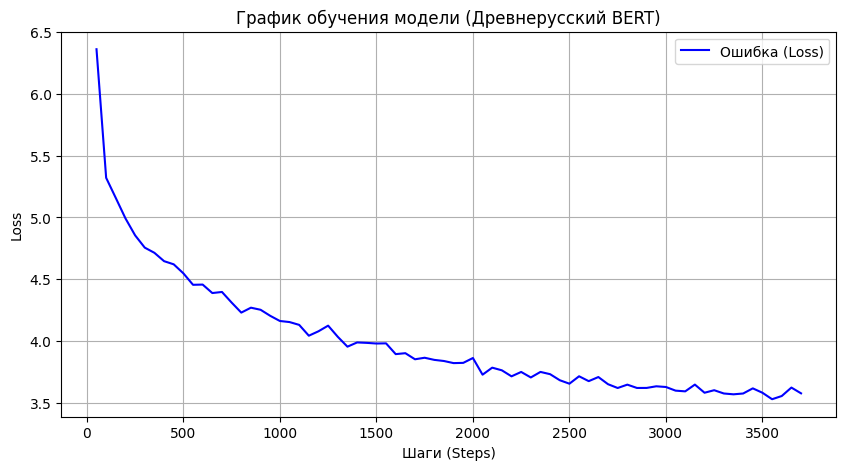

In [ ]:
import matplotlib.pyplot as plt

# Фильтруем историю, оставляем только записи с loss
history_loss = [x['loss'] for x in log_history if 'loss' in x]
history_steps = [x['step'] for x in log_history if 'loss' in x]

plt.figure(figsize=(10, 5))
plt.plot(history_steps, history_loss, label='Ошибка (Loss)', color='blue')
plt.title('График обучения модели (Древнерусский BERT)')
plt.xlabel('Шаги (Steps)')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
import math

# Берем последний известный Loss
if history_loss:
    final_loss = history_loss[-1]
    perplexity = math.exp(final_loss)

    print(f"📉 ФИНАЛЬНЫЕ МЕТРИКИ:")
    print(f"   • Final Loss: {final_loss:.4f}")
    print(f"   • Perplexity (ПП): {perplexity:.2f}")

    # Интерпретация
    if perplexity < 20:
        print("   ✅ Оценка: ОТЛИЧНО (Модель очень уверена в языке)")
    elif perplexity < 50:
        print("   ⚠️ Оценка: ХОРОШО (Модель понимает структуру, но иногда путает редкие слова)")
    else:
        print("   ❌ Оценка: ПЛОХО (Модель всё ещё гадает)")
else:
    print("Нет данных по Loss.")

📉 ФИНАЛЬНЫЕ МЕТРИКИ:
   • Final Loss: 3.5756
   • Perplexity (ПП): 35.72
   ⚠️ Оценка: ХОРОШО (Модель понимает структуру, но иногда путает редкие слова)
